# Introduction

The purpose of this kernel is to build a predictive model in domain of anomaly detection using Tennessee Eastman Process Simulation Dataset.

We will try several approaches such as statistical modelling, model based on predicting every feature separately and forecasting using LSTM to detect anomalies in the faulted data.

In [1]:
!pip install pyreadr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadr
import seaborn as sns
import scipy.stats as stats
import torch
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

sns.set()

     |████████████████████████████████| 225kB 4.5MB/s 


Using TensorFlow backend.


# Data preparation

The original dataset consists of RData files with normal and faulty processes datapoints. Assuming that in the real world we mostly have a big amount of data under the normal conditions we will train our models on it and test it on the data with faults. 

Let's convert this files in order to get two dataframes for train and test data. 

In [2]:
train_normal_path = '/kaggle/input/tennessee-eastman-process-simulation-dataset/TEP_FaultFree_Training.RData'
train_fault_path = '/kaggle/input/tennessee-eastman-process-simulation-dataset/TEP_Faulty_Training.RData'

train_df = pyreadr.read_r(train_normal_path)['fault_free_training']
test_df = pyreadr.read_r(train_fault_path)['faulty_training']

Now we have train_df and test_df dataframes which have data for normal working condition and data for fault 1 to 20. Total number of datapoints for normal data are 250 000 and 5 000 000 for the falty one with 55 features in both.

Total number of simulation runs is 500 for every condition. For the fault conditions faulty data is introduced after 1 hour of normal observations.

# EDA

Let's do some exploratory data analysis. What kind of data we are dealing with, is it normaly distributed, etc.

In [3]:
train_df.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [4]:
train_df.faultNumber.value_counts()

0.0    250000
Name: faultNumber, dtype: int64

In [5]:
test_df.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,1,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,1,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,1,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,1,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,1,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [6]:
test_df.faultNumber.value_counts()

20    250000
19    250000
2     250000
3     250000
4     250000
5     250000
6     250000
7     250000
8     250000
9     250000
10    250000
11    250000
12    250000
13    250000
14    250000
15    250000
16    250000
17    250000
18    250000
1     250000
Name: faultNumber, dtype: int64

> As we said the faulty conditions are described in the test_df (faultNumber > 0).

## Quantile-quantile plot

In [7]:
def qqplot_by_fault(data_df, cols, fault_number):
    plt.figure(figsize=(14,14))
    
    for i in range(len(cols)):
        ax = plt.subplot(4, 4, i+1)
        data = data_df[(data_df.faultNumber==fault_number) & (data_df.simulationRun.isin(range(10)))][cols[i]]
        
        #data = np.log(data)
        
        stats.probplot(x=data, plot=plt)
        ax.set_title(cols[i])
        ax.set_xlabel('')
        ax.set_ylabel('')
        shapiro = stats.shapiro(data)
        ax.text(0.99, 0.01, '{0:.4f}'.format(shapiro[1]),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='green', fontsize=15)
        
    plt.show()

At first let's check how similar are distributions of the features to the normal. The most convenient way to do it visually is the quantile-quantile plot. To make the result more objective we'll do a Shapiro-Wilk test for our data versus normal distribution and print the p_value.

### Normal conditions

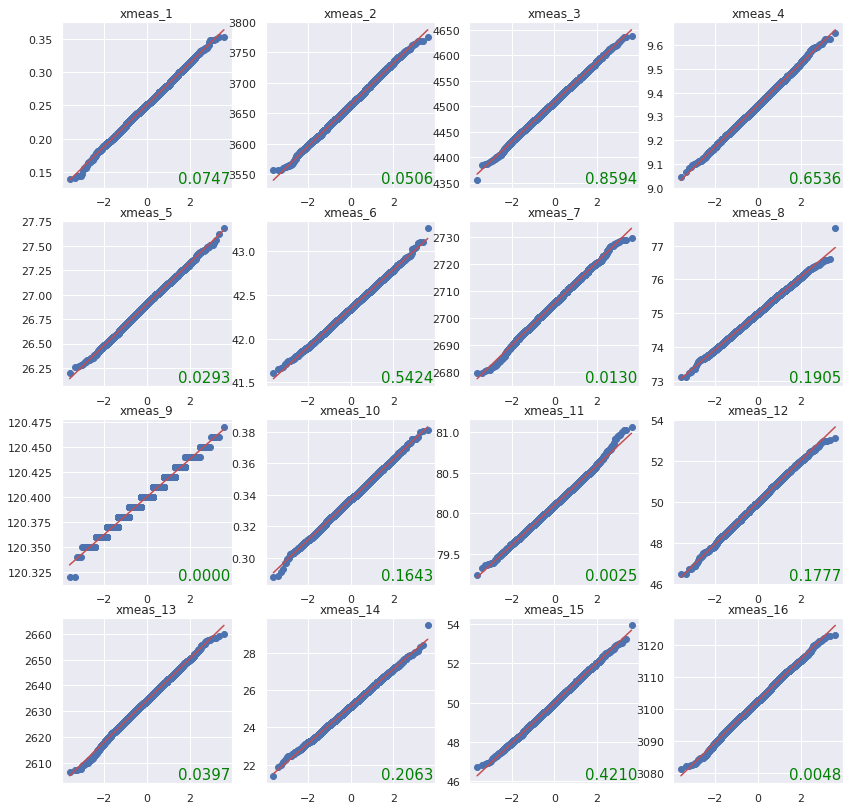

In [8]:
qqplot_by_fault(train_df, train_df.columns[3:19], fault_number=0)

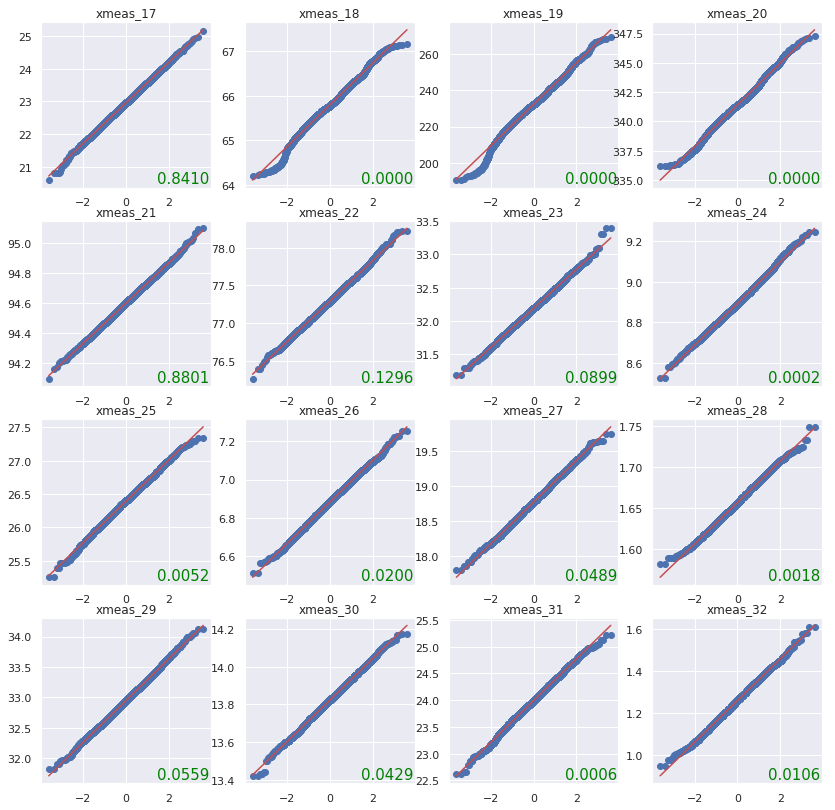

In [9]:
qqplot_by_fault(train_df, train_df.columns[19:35], fault_number=0)

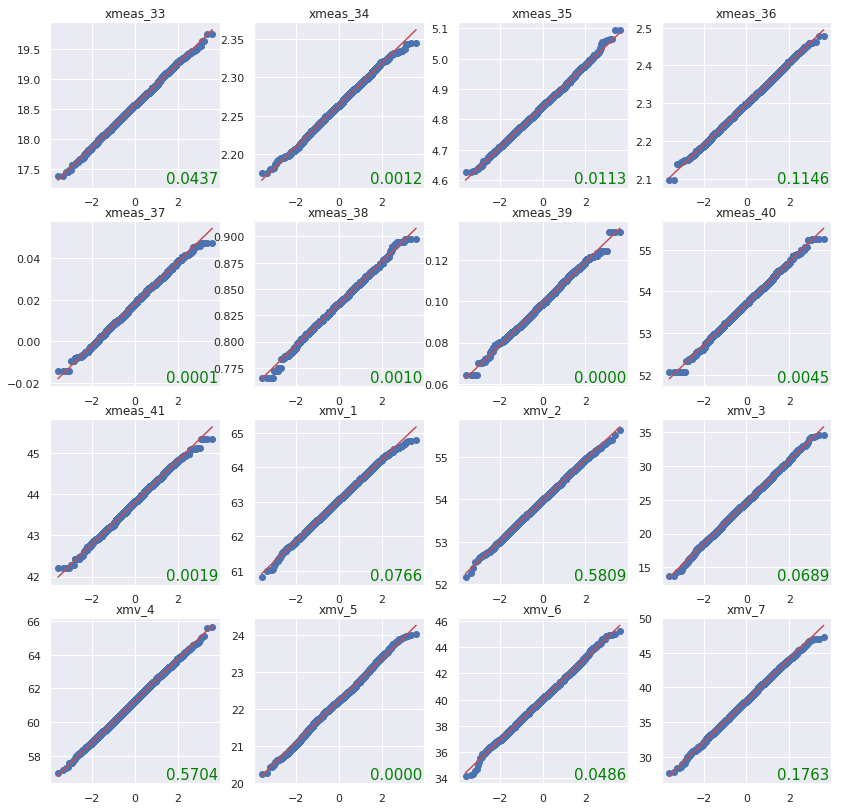

In [10]:
qqplot_by_fault(train_df, train_df.columns[35:51], fault_number=0)

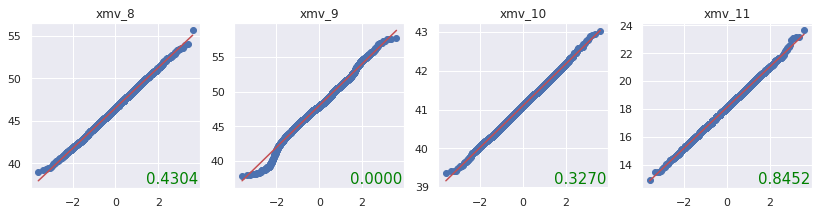

In [11]:
qqplot_by_fault(train_df, train_df.columns[51:], fault_number=0)

Under the normal conditions our data seems to be normaly distributed. Notice that __xmeas_9__ variable gets only discret values.

Now we'll observe some data during the different faults in order to understand how strong they can skew the initial distribution.

### Faulty conditions

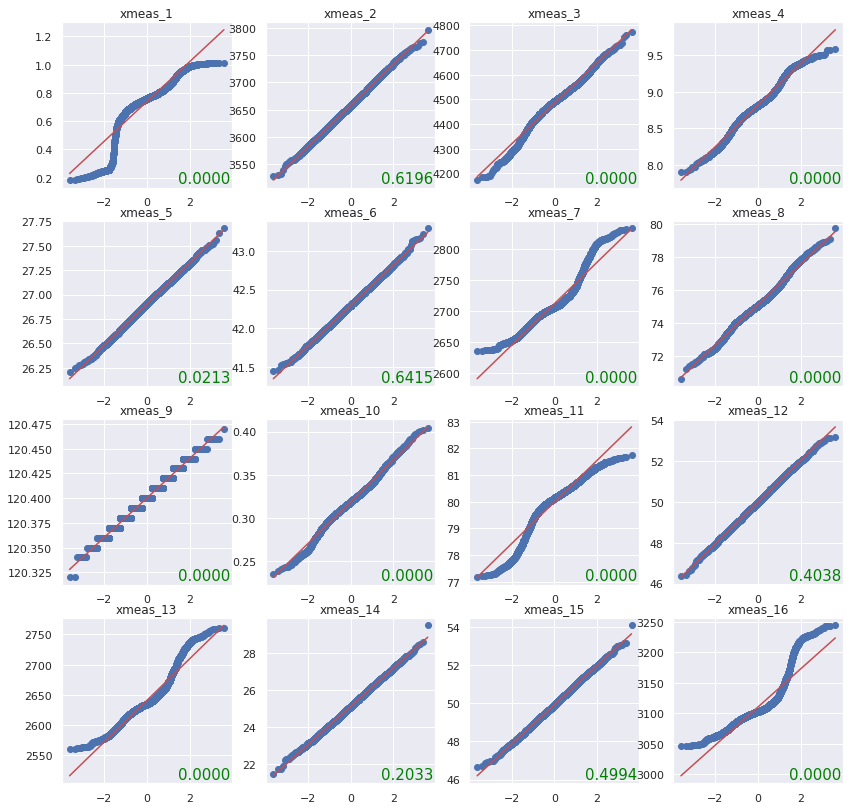

In [12]:
qqplot_by_fault(test_df, test_df.columns[3:19], fault_number=1)

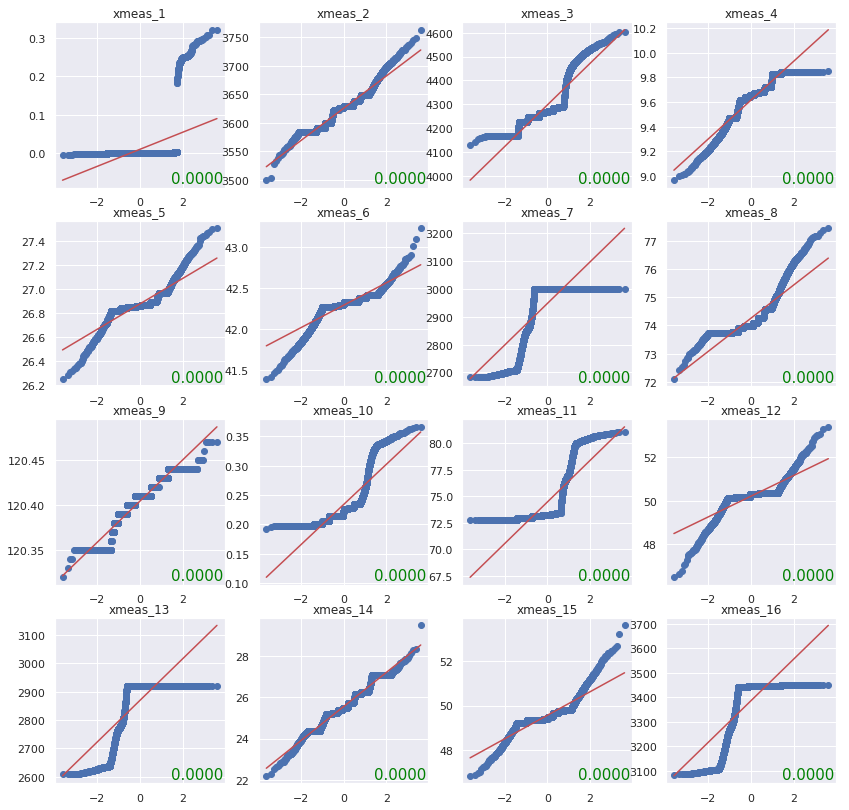

In [13]:
qqplot_by_fault(test_df, test_df.columns[3:19], fault_number=6)

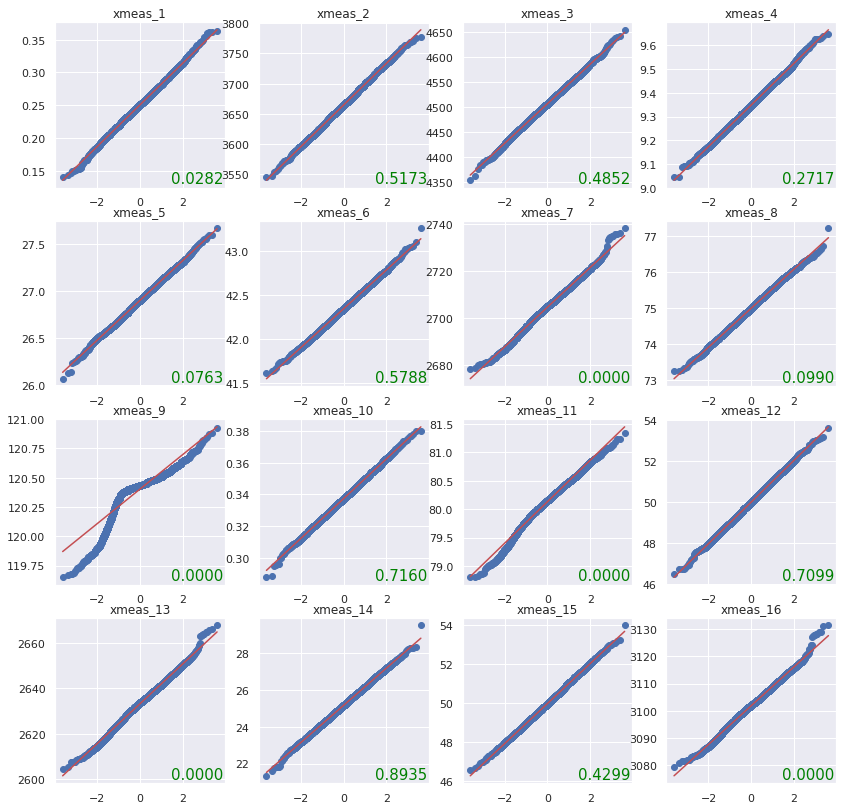

In [14]:
qqplot_by_fault(test_df, test_df.columns[3:19], fault_number=17)

If we investigate all the faults we will see that sometimes our data is significantly skewed from the normal distribution, but sometimes it's not true and faulty data remains to look like normaly distributed. At first let's find the faults which have skewed distribution and detect them using probabalistic model.

## How many feature distributions we can consider as normal?

Using the Shapiro-Wilk test with an alpha level 0.05 let's count the number of features that have almost normal distribution. If the statistics is above the given alpha level then we should accept null hypothesis (distribution is normal) and reject otherwise.

In [15]:
alpha = 0.05

def get_shapiro(data_df, cols, fault_number):
    shapiro_history = []
    for i in range(len(cols)):
        data = data_df[(data_df.faultNumber==fault_number) & (data_df.simulationRun.isin(range(9)))][cols[i]]
        #data = np.log(data)
        shapiro = stats.shapiro(data)
        shapiro_history.append(shapiro)
    return shapiro_history

def plot_shapiro(shapiro_history):
    W,p = zip(*shapiro_history)
    plt.plot(p)
    plt.axhline(y=alpha, color='r', linestyle='-')
    plt.title('p_value >= {0} for {1} features'.format(alpha, len([i for i in p if i >= alpha])))
    plt.xlabel('feature')
    plt.ylabel('p_value')
    plt.show()

### Normal conditions

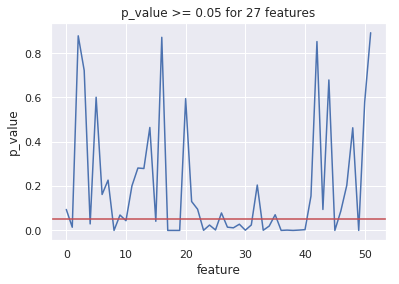

In [16]:
faultless_shapiro = get_shapiro(train_df, train_df.columns[3:55], fault_number=0)
plot_shapiro(faultless_shapiro)

w,p_values = zip(*faultless_shapiro)
faultless_cond = pd.DataFrame(index=train_df.columns[3:55],columns=['isNormal']).fillna(False)
i=0
for p in p_values:
    if p >= 0.05:
        faultless_cond.iloc[i] = True
    i+=1


For about a half of our features we can accept a __null hypothesis__ that the distribution is normal. It will be quite good if the faults are skewing the distribution significantly. 

### Faulty conditions

Let's do Shapiro-Wilk test for every feature on every condition and count the amount of features that we can consider as normal.

In [17]:
all_shap = []
for fault in range(1,21):
    shap = get_shapiro(test_df, test_df.columns[3:55], fault_number=fault)
    all_shap.append(shap)

In [18]:
fault_numbers = []
skewed_features = pd.DataFrame(index=train_df.columns[3:55],columns=['frequency']).fillna(0)

for i in range(20):
    w,p_values = zip(*all_shap[i])
    p_count = len([a for a in p_values if a >= 0.05])
    #print("%d -> %d" % (i + 1, p_count))
    if (p_count < 20):
        fault_numbers.append(i+1)
        
    feature_number = 0
    for p in p_values:
        if p < 0.05:
            skewed_features.iloc[feature_number] += 1
        feature_number+=1

#print("------------")
#print(len(fault_numbers))

#### Fault 2 — 12 features are still normal

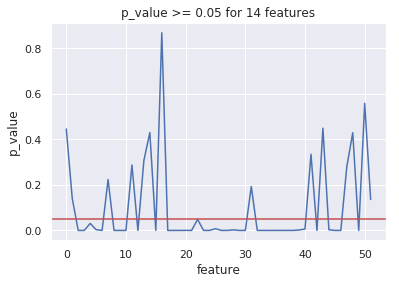

In [19]:
faulty_shapiro = get_shapiro(test_df, train_df.columns[3:55], fault_number=2)
plot_shapiro(faulty_shapiro)

#### Fault 6 — 0 features are normal

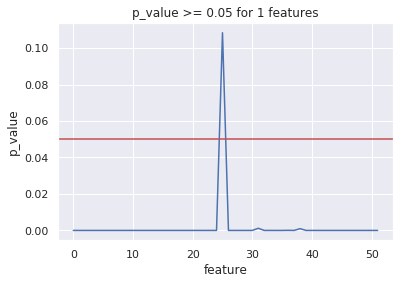

In [20]:
faulty_shapiro = get_shapiro(test_df, train_df.columns[3:55], fault_number=6)
plot_shapiro(faulty_shapiro)

#### Fault 20 — 24 features are still normal

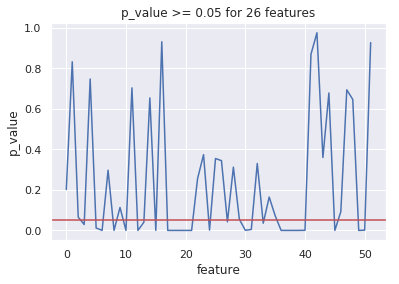

In [21]:
faulty_shapiro = get_shapiro(test_df, train_df.columns[3:55], fault_number=20)
plot_shapiro(faulty_shapiro)

After doing Shapiro-Wilk test we can say that some faults can be easily detected with the statistical methods and other not. We can try to detect the anomalies with the probabalistic model first.

# Probabalistic model

Parameters of our probalistic model will be the means and the variances of the feature distributions. Assuming that regular observations will be closer to the feature mean than faulty data we will receive a very small probability in the case of attack. It will be a signal that something is wrong.

## Feature selection



As far as we have the faulty data we can investigate which features will provide the strongest signal. Earlier we saved the features that are normally distributed under the regular conditions and we counted how often Shapiro-Wilk test gives the p_value below 0.05 during the faults for each feature (which means that the points are not normally distributed). Let's sort them and take the top n features.

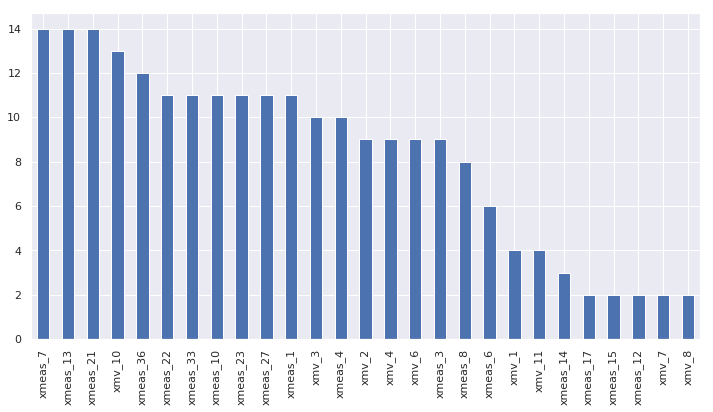

In [22]:
plt.figure(figsize=(12,6))

skewed_features[faultless_cond.isNormal.values].frequency.sort_values(ascending=False).plot(kind='bar');

In [23]:
n_prob_features=10

feature_cols = skewed_features[faultless_cond.isNormal].frequency.sort_values(ascending=False).head(n_prob_features).index.values
print(feature_cols)

['xmeas_7' 'xmeas_13' 'xmeas_21' 'xmv_10' 'xmeas_36' 'xmeas_22' 'xmeas_33'
 'xmeas_10' 'xmeas_23' 'xmeas_27']


Now let's scale the features to get more stable parameters and train the model — calculate means and variances.

In [24]:
scaler = preprocessing.MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(X = train_df[(train_df.faultNumber == 0) & (train_df.simulationRun.isin(range(400)))].loc[:,feature_cols]))

means = data.mean()
variances = data.std()

model_prob = pd.DataFrame(index = feature_cols, data = {'mean': means.values, 'variance': variances.values})
model_prob.head(n_prob_features)

,mean,variance
xmeas_7,0.490172,0.113015
xmeas_13,0.493977,0.111739
xmeas_21,0.490483,0.110456
xmv_10,0.471319,0.101071
xmeas_36,0.500548,0.120703
xmeas_22,0.505249,0.113515
xmeas_33,0.477033,0.114613
xmeas_10,0.473183,0.114341
xmeas_23,0.497545,0.118902
xmeas_27,0.522407,0.122750


To evaluate the new datapoint we calculate the probability for each feature included in our model and return the product of probabilities. It will be the probability to get the given data point.

In [25]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def get_probability(x, model):
    res = gaussian(x.values, model['mean'].values, model['variance'].values)
    return res.prod()

def alert_condition(x):
    return np.max(x)

def metric_prob(probs, window_minutes, eps):    
    #samples are sampled each 3 minutes
    window_points = window_minutes // 3
    rolled = probs.rolling(window=window_points).apply(alert_condition, raw=True)    
    ind = np.where(rolled < eps)
    
    if len(ind[0])>0:
        return ind[0][0]

    return 0

## Results

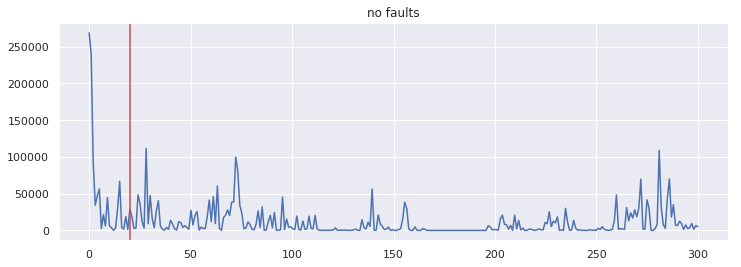

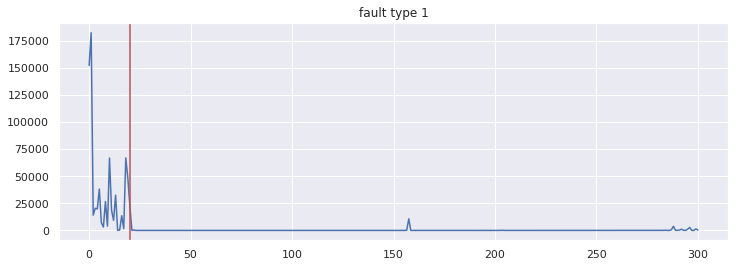

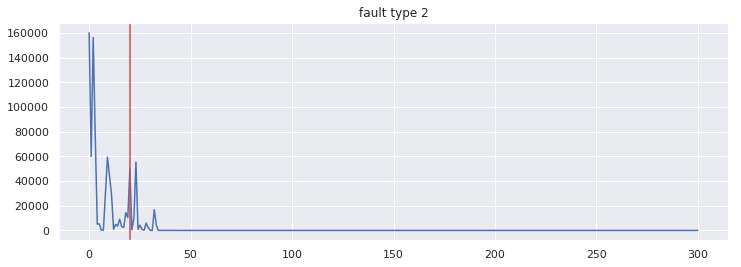

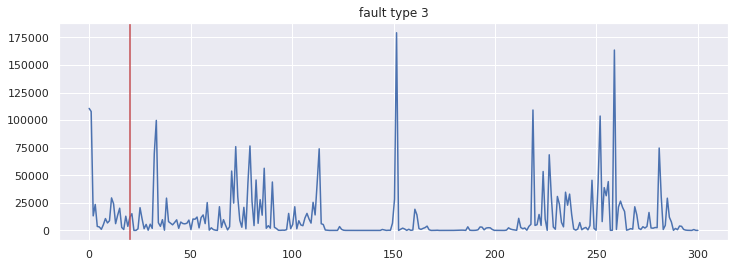

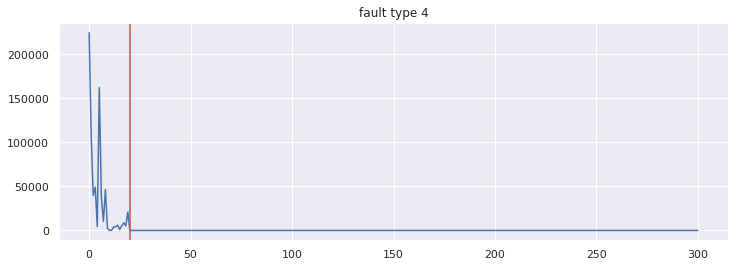

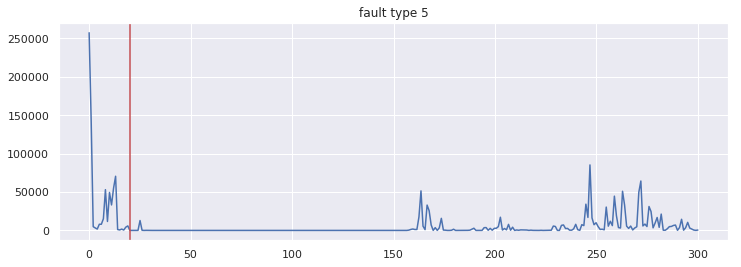

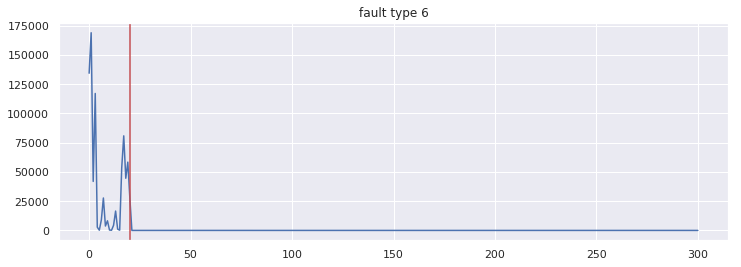

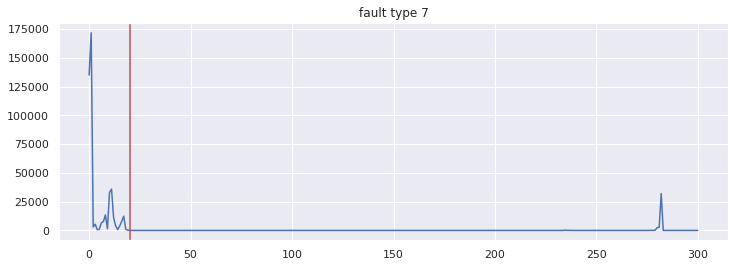

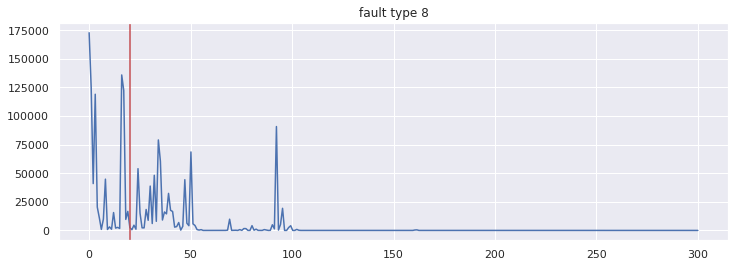

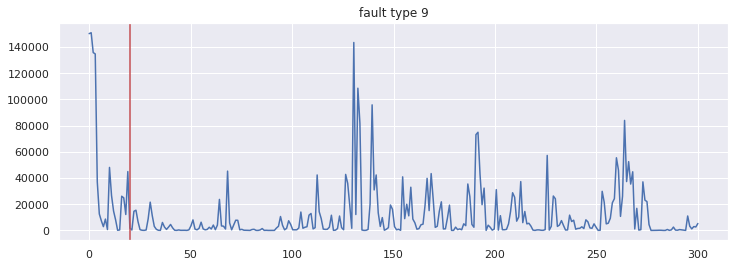

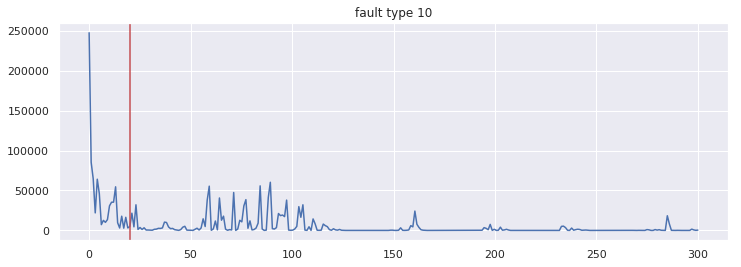

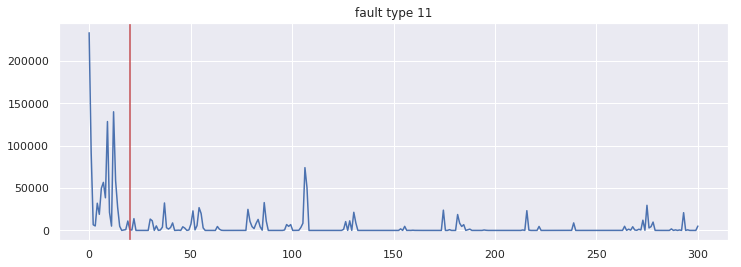

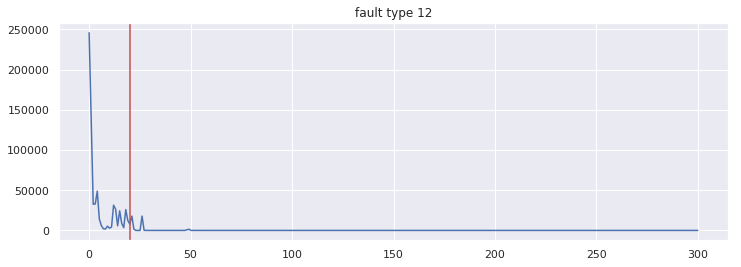

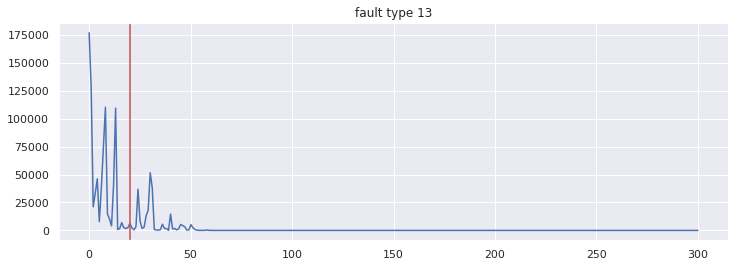

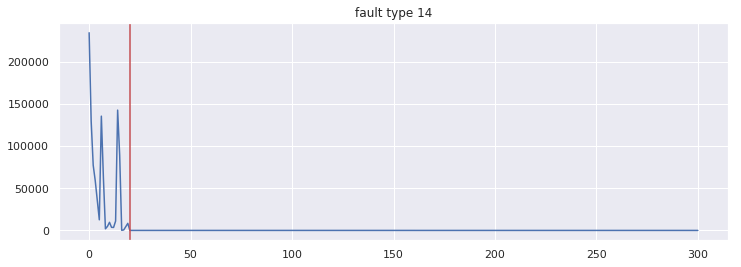

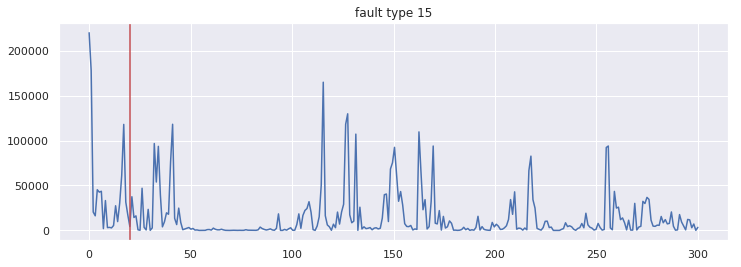

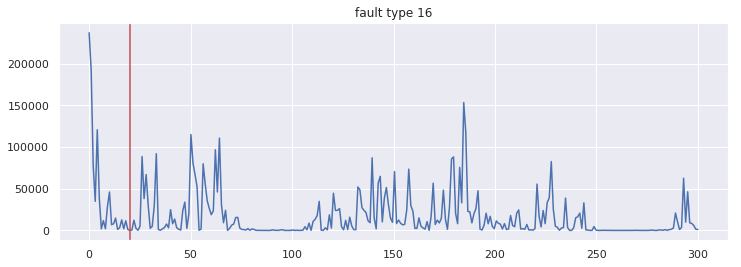

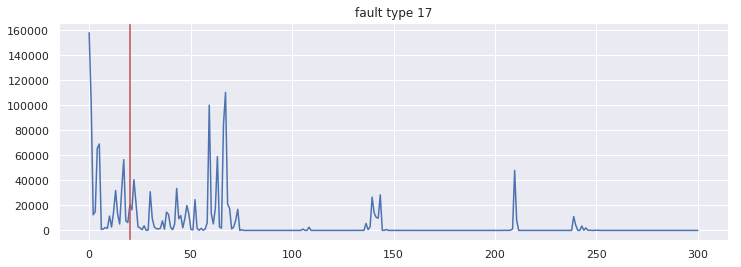

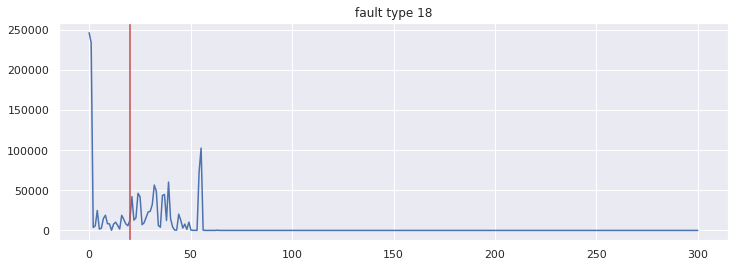

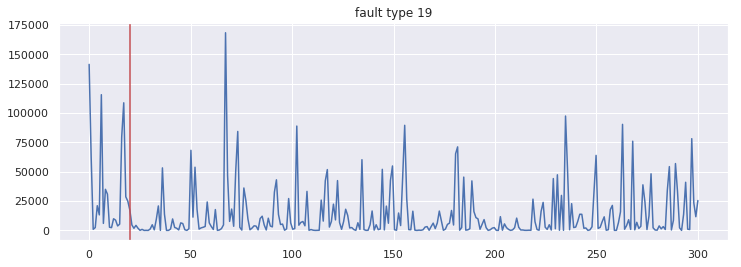

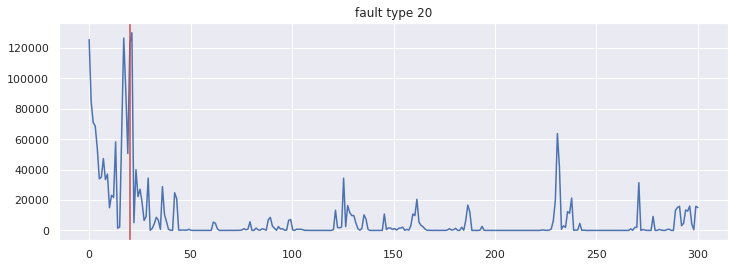

In [26]:
for fault in range(21):
    plt.figure(figsize=(12,4))
    if fault==0:
        scaled = pd.DataFrame(scaler.transform(train_df[(train_df.faultNumber == fault) & (train_df.simulationRun == 401)].loc[:, feature_cols]))
        plt.title('no faults')
    else:
        scaled = pd.DataFrame(scaler.transform(test_df[(test_df.faultNumber == fault) & (test_df.simulationRun == np.random.randint(500))].loc[:, feature_cols]))
        plt.title('fault type {0}'.format(fault))
    probs = scaled.apply(lambda x: get_probability(x, model_prob), axis=1)
    
    plt.plot(np.linspace(0,300,300), probs[:300])    
    plt.axvline(x=20, color='r', linestyle='-')

    #alert_point = metric_prob(probs, 30, 1e+05)
    #window_points = 10
    #plt.axvline(x=alert_point, color='y', linestyle='--')
    #plt.axvline(x=alert_point-window_points, color='y', linestyle='--')

    plt.show()

So, with this model we're able to detect faults when the feature distributions distantiating from normal. We're calculating the probability to meet the new data and if it's below some threshold we can show the alarm. In case when fault didn't skew the distribution from normal this method won't be robust.

The further development of this method is to use the multivariate normal distribution. It will automatically capture the correlations between features.

# Ensembling

In this approach we will train N simple models for N features. Every model will be able to predict a single feature by the others. On faulty conditions the differenece between target and prediction should increase. After that we will calculate the MSE along all the predictions for the new data.

## Steps

- Prepare the data
- Train N models to predict 1 feature by other N-1 features on train data
- Predict features on the test data points
- Calculate MSE

As earlier we will scale our data first using the MinMaxScaler. Then we will take all our features because

In [27]:
scaler = preprocessing.MinMaxScaler()

features_df = train_df[train_df.faultNumber==0].iloc[:,3:]
features_df = pd.DataFrame(scaler.fit_transform(X = features_df), columns = features_df.columns)

In [28]:
def train(df, cols_to_predict):
    models = {}
    for col in cols_to_predict:
        print('training model for', col)
        model = lgb.LGBMRegressor(learning_rate=0.1)
        tr_x = features_df.drop([col],axis=1)
        target = features_df[col]
        
        model.fit(X=tr_x, y=target)
        models[col] = model
    
    return models

def predict(models, df, cols_to_predict):
    preds = []
    for col in cols_to_predict:
        test_x = df.drop([col],axis=1)
        test_y = df[col]
        pred = models[col].predict(test_x)
        preds.append(pred)
        
        #err.append(np.square((test_y - pred)**2).values)
        
        #plt.figure(figsize=(15,10))
        #x = np.linspace(0,len(test_y),len(test_y))
        #plt.plot(x, test_y, label='Actual value')
        #plt.plot(x, pred, label='Prediction')
        #plt.legend(loc='best')
        #plt.title(col)
        #plt.plot()
        #plt.show()
        
        #qqplot_data(pred)
    
    return preds

In [29]:
features_to_predict = train_df.columns[3:]
models = train(train_df[(train_df.faultNumber==0) & (train_df.simulationRun.isin(range(400)))], features_to_predict)

training model for xmeas_1
training model for xmeas_2
training model for xmeas_3
training model for xmeas_4
training model for xmeas_5
training model for xmeas_6
training model for xmeas_7
training model for xmeas_8
training model for xmeas_9
training model for xmeas_10
training model for xmeas_11
training model for xmeas_12
training model for xmeas_13
training model for xmeas_14
training model for xmeas_15
training model for xmeas_16
training model for xmeas_17
training model for xmeas_18
training model for xmeas_19
training model for xmeas_20
training model for xmeas_21
training model for xmeas_22
training model for xmeas_23
training model for xmeas_24
training model for xmeas_25
training model for xmeas_26
training model for xmeas_27
training model for xmeas_28
training model for xmeas_29
training model for xmeas_30
training model for xmeas_31
training model for xmeas_32
training model for xmeas_33
training model for xmeas_34
training model for xmeas_35
training model for xmeas_36
t

## Results

Let's take random samples for a normal and faulty cases, infer the predictions and plot the MSE values.

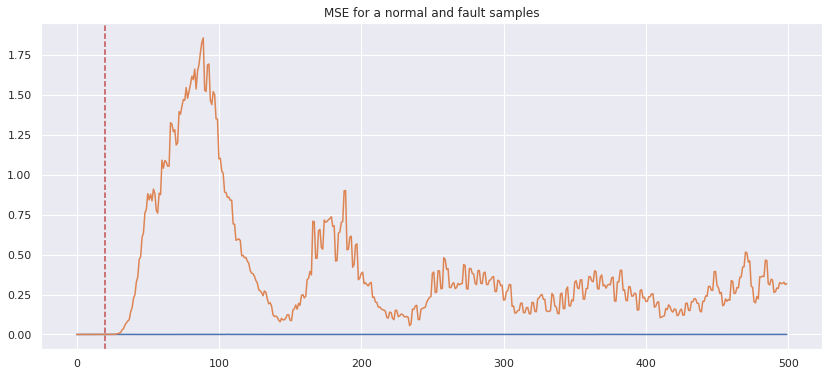

In [30]:
def get_mse(sample, preds):
    return np.square((sample.loc[:,features_to_predict] - np.transpose(preds))**2).mean(axis=1)

plt.figure(figsize=(14,6))

normal_sample = pd.DataFrame(scaler.transform(train_df[(train_df.simulationRun==np.random.randint(500)) & (train_df.faultNumber==0)].iloc[:,3:]), columns = features_df.columns)
normal_preds = predict(models, normal_sample, features_to_predict)

faulty_sample = pd.DataFrame(scaler.transform(test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==1)].iloc[:,3:]), columns = features_df.columns)
faulty_preds = predict(models, faulty_sample, features_to_predict)

plt.axvline(x=20,color='r',linestyle='--')

plt.title('MSE for a normal and fault samples')
plt.plot(get_mse(normal_sample, normal_preds));
plt.plot(get_mse(faulty_sample, faulty_preds));

Plot the same chart, but with the logarithmic scale to consider which treshold we should use for the anomaly detection.

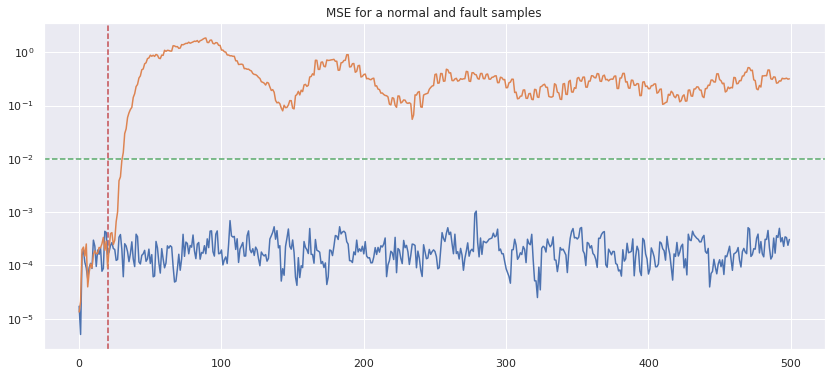

In [31]:
plt.figure(figsize=(14,6))
plt.yscale('log')

plt.axvline(x=20,color='r',linestyle='--')
plt.axhline(y=1e-2,color='g',linestyle='--')

plt.title('MSE for a normal and fault samples')
plt.plot(get_mse(normal_sample, normal_preds));
plt.plot(get_mse(faulty_sample, faulty_preds));

Now let's try the different types of to explore how our model reacting on them.

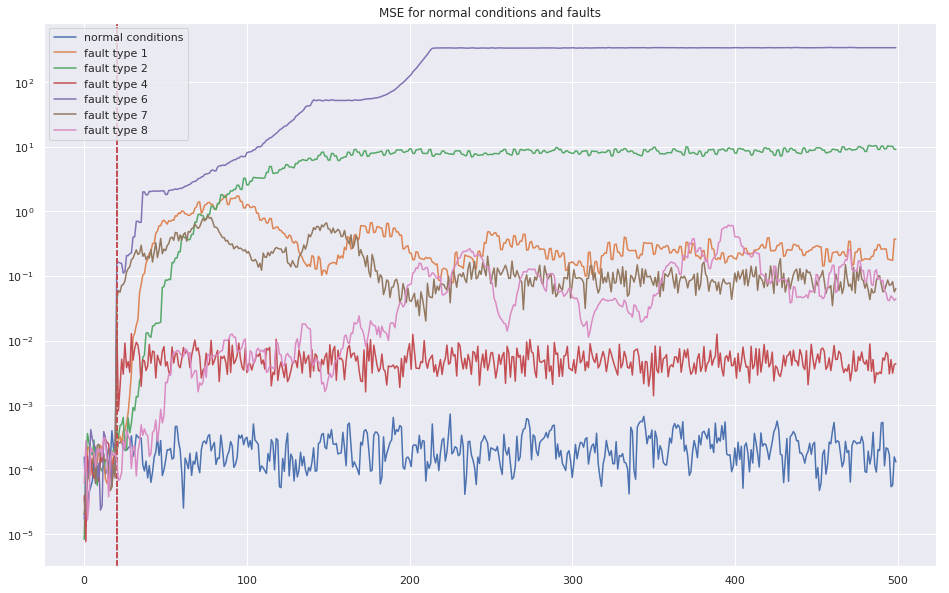

In [32]:
plt.figure(figsize=(16,10))
plt.yscale('log')

for i in [0,1,2,4,6,7,8]:
    if i == 0:
        tree_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        tree_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
    tree_sample = pd.DataFrame(scaler.transform(tree_sample), columns = features_df.columns)
    tree_preds = predict(models, tree_sample, features_to_predict)
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(get_mse(tree_sample,tree_preds),label=label)
    plt.title('MSE for normal conditions and faults')
    plt.legend()

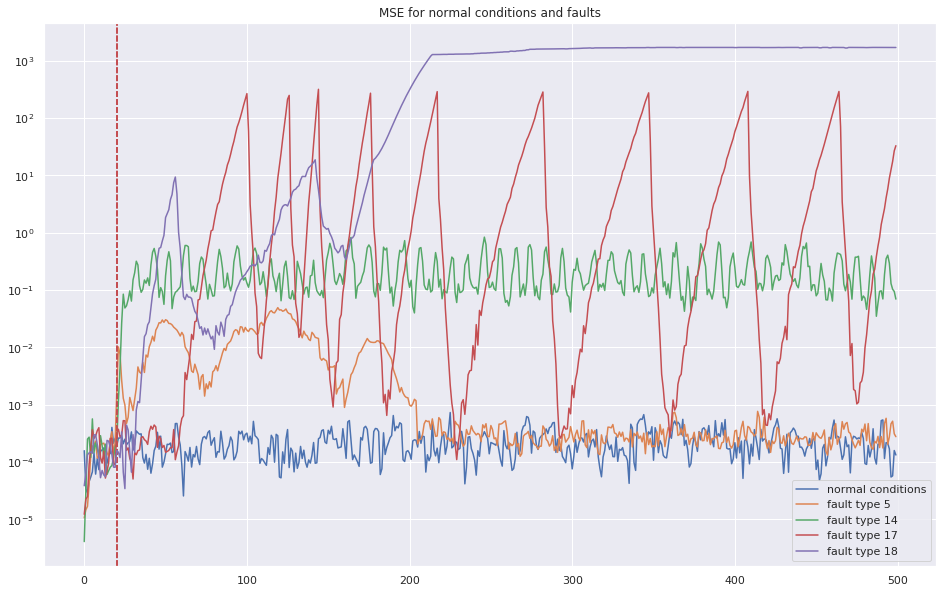

In [33]:
plt.figure(figsize=(16,10))
plt.yscale('log')

#11,12,13
for i in [0,5,14,17,18]:
    if i == 0:
        tree_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        tree_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
    tree_sample = pd.DataFrame(scaler.transform(tree_sample), columns = features_df.columns)
    tree_preds = predict(models, tree_sample, features_to_predict)
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(get_mse(tree_sample,tree_preds),label=label)
    plt.title('MSE for normal conditions and faults')
    plt.legend()

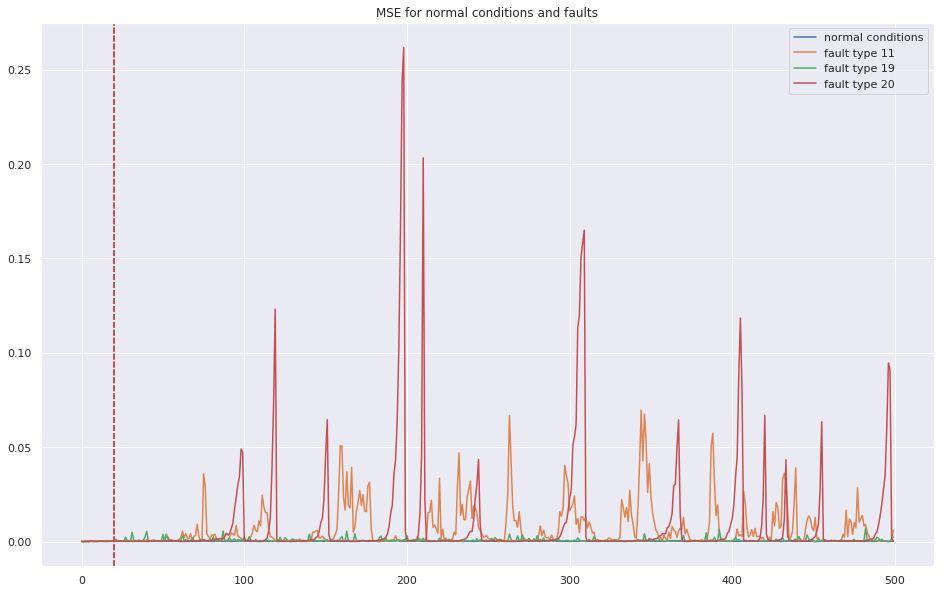

In [34]:
plt.figure(figsize=(16,10))
#plt.yscale('log')

for i in [0,11,19,20]:
    if i == 0:
        tree_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        tree_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
    tree_sample = pd.DataFrame(scaler.transform(tree_sample), columns = features_df.columns)
    tree_preds = predict(models, tree_sample, features_to_predict)
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(get_mse(tree_sample,tree_preds),label=label)
    plt.title('MSE for normal conditions and faults')
    plt.legend()

As we can see our ensembled model based on the simple decision tree models (it can be any other kind of models) can deal with almost all error types in this dataset and we didn't tweak the LGBM parameters yet. The downside of it that it didn't use the time series information from the past and it can be not reliable on the non stationary sequences.

# LSTM

LSTM stands for long short-term memory. It's a recurrent type of neural network that keeping the information of the previous states which help it catch the sequence patterns.

Using some pandas tricks we prepare the data for feeding to the training loop. We're using only clean data for training and validating purposes, because in real cases there might be no or not much data with fauly datapoints.

In [35]:
def series_to_lstm(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    #columns = data.columns
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%d(t-%d)' % (j, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%d(t)' % (j)) for j in range(n_vars)]
        else:
            names += [('%d(t+%d)' % (j, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [36]:
scaler = preprocessing.MinMaxScaler()

dat = train_df[(train_df.faultNumber==0) & (train_df.simulationRun.isin(range(200)))]
dat = dat.iloc[:,3:]
dat = scaler.fit_transform(dat)
print(dat.shape)
#dat.head()

test = train_df[(train_df.faultNumber==0) & (train_df.simulationRun.isin(range(400,500)))]
test = test.iloc[:,3:]
test = scaler.transform(test)
print(test.shape)

(99500, 52)
(50000, 52)


In [37]:
time_steps = 10

ref = series_to_lstm(dat,time_steps,1)
print(ref.shape)

ref_test = series_to_lstm(test,time_steps,1)
print(ref_test.shape)

(99490, 572)
(49990, 572)


In [38]:
train_x = ref.values[:,:-52]
train_y = ref.values[:,-52:]
train_x = train_x.reshape(train_x.shape[0],time_steps,train_x.shape[1]//time_steps)

test_x = ref_test.values[:,:-52]
test_y = ref_test.values[:,-52:]
test_x = test_x.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)

In [39]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(99490, 10, 52)
(99490, 52)
(49990, 10, 52)
(49990, 52)


Train on 99490 samples, validate on 49990 samples
Epoch 1/25
 - 21s - loss: 0.0127 - val_loss: 0.0095
Epoch 2/25
 - 21s - loss: 0.0086 - val_loss: 0.0080
Epoch 3/25
 - 20s - loss: 0.0077 - val_loss: 0.0074
Epoch 4/25
 - 20s - loss: 0.0072 - val_loss: 0.0071
Epoch 5/25
 - 20s - loss: 0.0070 - val_loss: 0.0069
Epoch 6/25
 - 19s - loss: 0.0069 - val_loss: 0.0068
Epoch 7/25
 - 21s - loss: 0.0068 - val_loss: 0.0068
Epoch 8/25
 - 19s - loss: 0.0068 - val_loss: 0.0067
Epoch 9/25
 - 19s - loss: 0.0067 - val_loss: 0.0067
Epoch 10/25
 - 20s - loss: 0.0067 - val_loss: 0.0067
Epoch 11/25
 - 20s - loss: 0.0067 - val_loss: 0.0067
Epoch 12/25
 - 19s - loss: 0.0067 - val_loss: 0.0066
Epoch 13/25
 - 20s - loss: 0.0066 - val_loss: 0.0066
Epoch 14/25
 - 19s - loss: 0.0066 - val_loss: 0.0066
Epoch 15/25
 - 19s - loss: 0.0066 - val_loss: 0.0066
Epoch 16/25
 - 20s - loss: 0.0066 - val_loss: 0.0066
Epoch 17/25
 - 20s - loss: 0.0066 - val_loss: 0.0066
Epoch 18/25
 - 20s - loss: 0.0066 - val_loss: 0.0066
Epoch

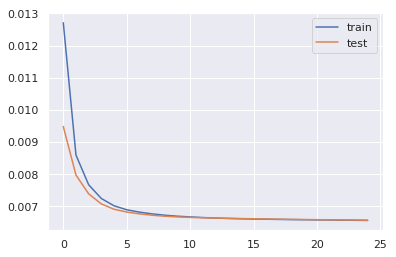

In [40]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model_lstm.add(Dense(52))
model_lstm.compile(loss='mse', optimizer='adam')

#with tf.device('/gpu:0'):
history = model_lstm.fit(train_x, train_y, epochs=25, batch_size=50, validation_data=(test_x, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Results

As earlier we're taking random samples for a normal and faulty cases, infer the predictions and plot the MSE values. We will see that the MSE amount is decreasing after the data becoming faulty.

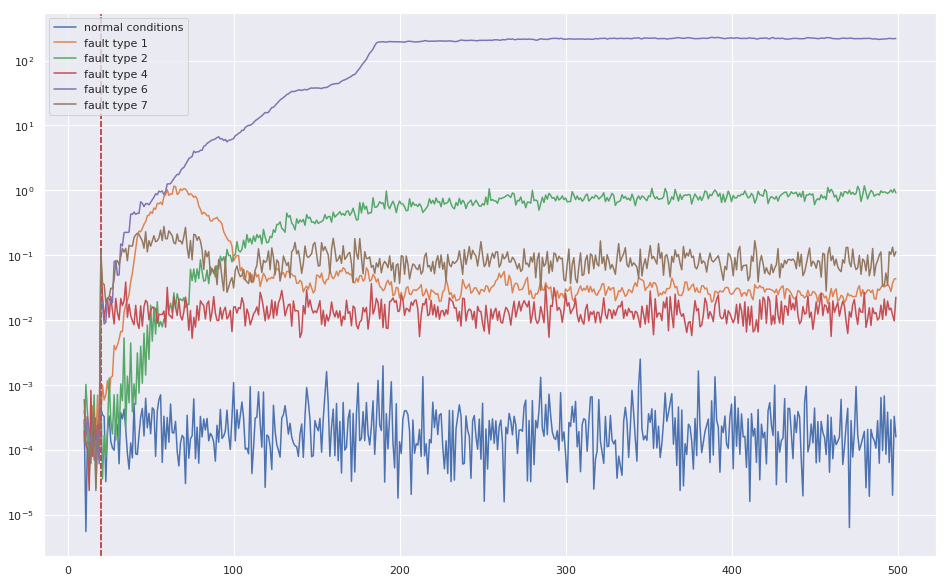

In [41]:
plt.figure(figsize=(16,10))
plt.yscale('log')

for i in [0,1,2,4,6,7]:    
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)
    plt.legend()
    


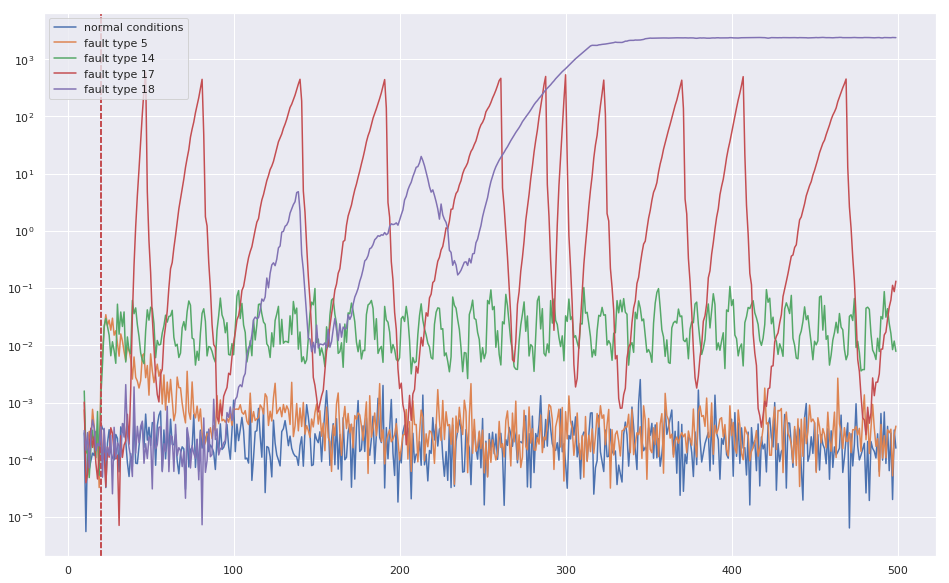

In [42]:
plt.figure(figsize=(16,10))
plt.yscale('log')

for i in [0,5,14,17,18]:    
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)
    plt.legend()

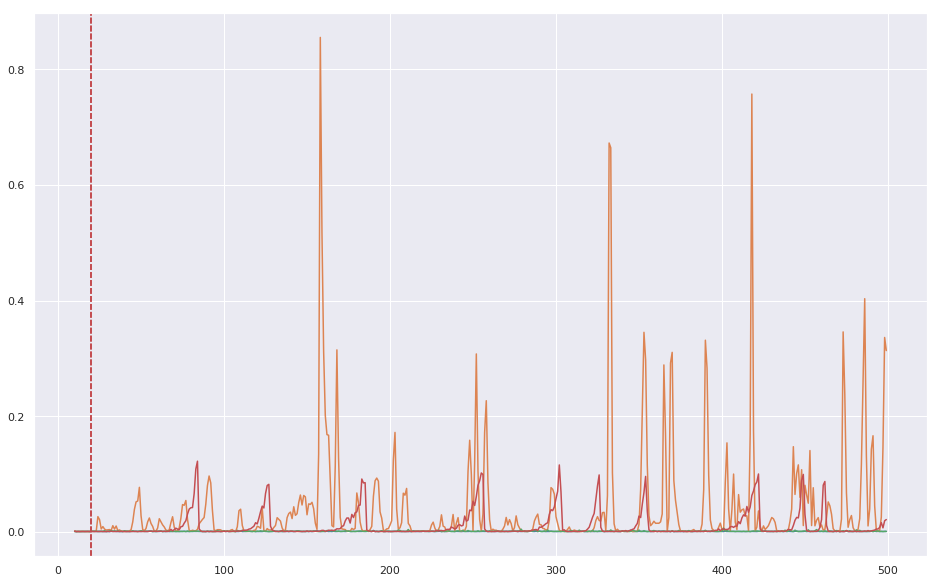

In [43]:
plt.figure(figsize=(16,10))

for i in [0,11,19,20]:
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)

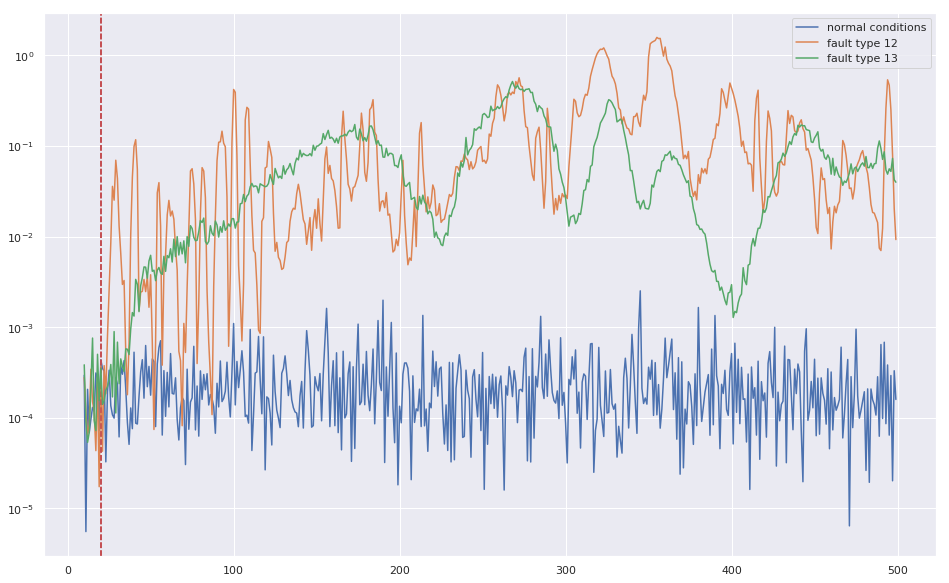

In [44]:
plt.figure(figsize=(16,10))
plt.yscale('log')

for i in [0,12,13]:    
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)
    plt.legend()

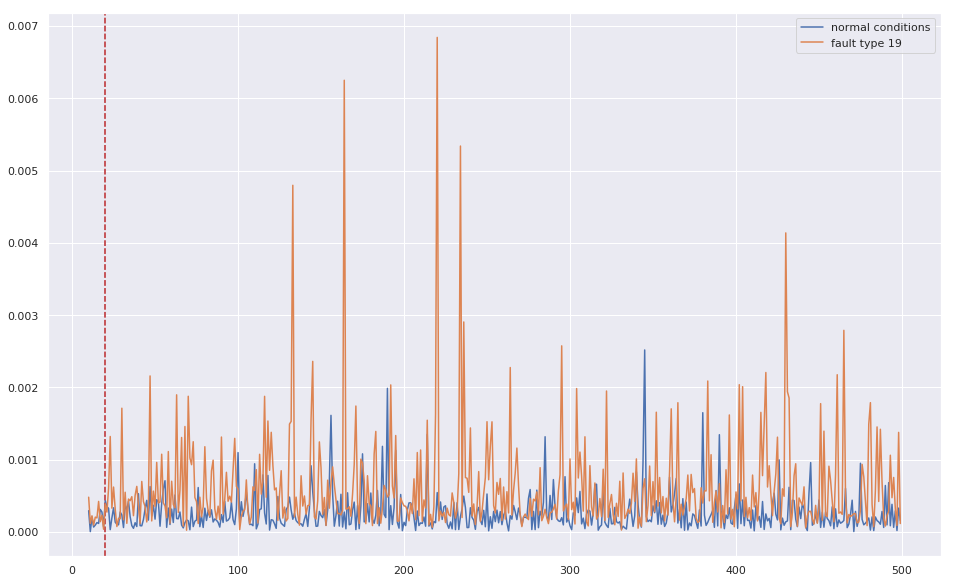

In [45]:
plt.figure(figsize=(16,10))

for i in [0,19]:    
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)
    plt.legend()

We see that LSTM model does a pretty decent job in a novelty detecion task. It can be further improved by tweaking the model architecture and hyperparameters. We can also do a multiple timesteps predictions. 

# Take away

* Investigate you data first (normal distribution, seasonability, etc.).
* Probabalistic methods can be implemented if you have not much data.
* LSTM method need a lot of data to implement a robust model.
* Ensembling of many weak models can give a good results.